Edgic Analysis
==


### Connect to Reddit API
Establish connection to Reddit via the Python Reddit API Wrapper

In [5]:
import praw
import re
import pandas as pd
from praw.models import MoreComments
import numpy as np
from datetime import datetime, timezone
import json
from collections import OrderedDict

# Track date of data pull
pull_date = datetime.now().strftime("%b %d %Y %H:%M:%S")

# Create connection to Reddit via PRAW
fp = open('./settings.json')
settings = json.load(fp).get('praw')
reddit = praw.Reddit(client_id = settings.get('client_id'),
                    client_secret = settings.get('client_secret'),
                    user_agent = settings.get('user_agent'),
                    username = settings.get('username'),
                    password = settings.get('password'))
subreddit = reddit.subreddit('edgic')

fp = open('./edgic-seasons.json')
#seasons = json.load(fp)
seasons = {"40":"Winners at War"}

readData = True

### Pull all required data

In [67]:
pattern0 = re.compile(r'[0-9]*?\.?[0-9]*?\s+:\s+.+\s+\(.+\)$', re.MULTILINE)
pattern1 = re.compile(r'[0-9]*?\.?[0-9]*?\s+:\s+.+$', re.MULTILINE)
pattern2 = re.compile(r'[a-zA-Z ]*?\s+-\s+[0-9]*?\.?[0-9]+?$', re.MULTILINE)
pattern3 = re.compile(r'[a-zA-Z ]*?\s+:\s+[0-9]*?\.?[0-9]+?$', re.MULTILINE)
pattern4 = re.compile(r'[a-zA-Z ]*?\s*:\s+[0-9]*?\.?[0-9]+?$', re.MULTILINE)

edgic_results = {}
for season in seasons.values():
    season_results = OrderedDict()
    submissions = subreddit.search("Edgic Results, "+season,sort='new')
    print("-------------")
    print(season)
    print("-------------")
    for sub in submissions:
        if str(sub.author) == "DesertScorpion4":
            title = sub.title.replace("Edgic Results","").replace(season,"").replace(":","").strip()
            text = None
            if pattern0.search(sub.selftext):
                text = {t.split(":")[1].split("(")[0].replace("*","").replace("The Abstract Concept of the Second","").strip() : float(t.split(":")[0].strip()) for t in pattern1.findall(sub.selftext)}
            elif pattern1.search(sub.selftext):
                text = {t.split(":")[1].replace("*","").strip() : float(t.split(":")[0].strip()) for t in pattern1.findall(sub.selftext)}
            elif pattern2.search(sub.selftext):
                text = {t.split("-")[0].strip() : float(t.split("-")[1].strip()) for t in pattern2.findall(sub.selftext)}
            elif pattern3.search(sub.selftext):
                text = {t.split(":")[0].strip() : float(t.split(":")[1].strip()) for t in pattern3.findall(sub.selftext)}
            elif pattern4.search(sub.selftext):
                text = {t.split(":")[0].strip() : float(t.split(":")[1].strip()) for t in pattern4.findall(sub.selftext)}
            
            if(not text):
                print(f"Pattern match not found for the following submission:\nTitle: {title}\nBody:\n{sub.selftext}")
                print("===========")
            season_results[title] = text
    edgic_results[season] = OrderedDict(list(season_results.items())[::-1])

-------------
Winners at War
-------------
{'Winners at War': OrderedDict([('Episode 1', {'Yul Kwon': 4.26, 'Sophie Clarke': 4.03, 'Tyson Apostol': 3.94, 'Parvati Shallow': 3.34, 'Ethan Zohn': 3.22, 'Wendell Holland': 3.2, 'Tony Vlachos': 2.99, 'Danni Boatwright': 2.74, 'Jeremy Collins': 2.63, 'Nick Wilson': 2.6, 'Rob Mariano': 2.59, 'Sandra Diaz-Twine': 2.43, 'Adam Klein': 2.38, 'Denise Stapley': 2.23, 'Kim Spradlin-Wolfe': 1.97, 'Ben Driebergen': 1.97, 'Sarah Lacina': 1.92, 'Michele Fitzgerald': 1.9, 'Natalie Anderson': 1.31, 'Amber Mariano': 1.31}), ('Episode 2', {'Sophie Clarke': 4.48, 'Yul Kwon': 3.86, 'Tyson Apostol': 3.79, 'Tony Vlachos': 3.47, 'Adam Klein': 3.22, 'Ethan Zohn': 2.93, 'Parvati Shallow': 2.82, 'Wendell Holland': 2.79, 'Jeremy Collins': 2.77, 'Denise Stapley': 2.61, 'Rob Mariano': 2.44, 'Sarah Lacina': 2.25, 'Kim Spradlin-Wolfe': 2.08, 'Sandra Diaz-Twine': 2.08, 'Ben Driebergen': 2.06, 'Natalie Anderson': 1.77, 'Michele Fitzgerald': 1.75, 'Nick Wilson': 1.73, 'Ambe

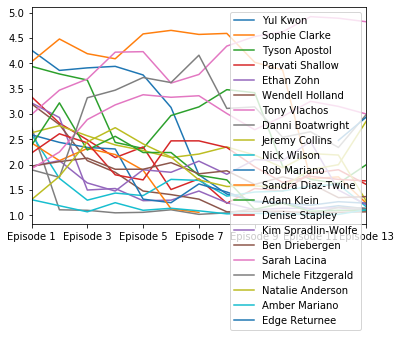

In [68]:
# Make graph for IoI
IoI = edgic_results["Winners at War"]
df = pd.DataFrame(IoI, columns=IoI.keys())
df.transpose()
df.transpose().plot()

### Save results

In [72]:
for season in seasons.values():
    data = edgic_results[season]    
    df = pd.DataFrame(data, columns=data.keys())
    # Save csv for reference
    df_format = df.transpose().reset_index().rename(columns={'index':'Episode'})
    df_format.to_csv(f'./data/{season}_contender_rankings.csv', header=True, index=None)

### Read in results

In [69]:
def read_df(season):
    df = pd.read_csv(f"./data/{season}_contender_rankings.csv")
    results = pd.read_csv("./data/contestants-results.csv")
    df_pivot = pd.DataFrame(columns=['Episode','name','rank','finish','vote out','finalist'])
    for col in df.columns:
        df_new = pd.DataFrame(columns=['Episode','name','rank','finish','vote out','finalist'])
        if not col == 'Episode':
            res = results.loc[(results["Season"]==season) & (results['name']==col)].set_index(["name", "Vote Out"])
            res['last episode'] = ['Finale' if x=='FTC' else x for x in res.reset_index()['Vote Out']]
            df_new['Episode'] = df['Episode']
            df_new['name'] = col
            df_new['rank'] = df[col]
            df_tmp=pd.merge(df_new, res.reset_index()[['name','last episode','Vote Out']], how='left', left_on=['name','Episode'], right_on=['name','last episode'])
            df_tmp2=pd.merge(df_new, res.reset_index()[['name','Rank']].dropna(), how='left', left_on=['name'], right_on=['name'])
            df_new['vote out'] = df_tmp['last episode']==df_tmp['Episode']
            df_new['FTC'] = df_tmp['Vote Out']=='FTC'
            df_new['finish'] = df_tmp2['Rank']
            df_new['finalist'] = df_new['finish']<6
            df_pivot = pd.concat([df_pivot, df_new], sort=False)
    data = df_pivot.reset_index(drop=True)
    # print(data.loc[data['vote out']==True])
    for x in data.loc[data['vote out']==True].index.values:
        #if not data.loc[x,'rank']>0:
        data.loc[x,'rank'] = data.loc[x-1,'rank']
    # print(data.loc[data['vote out']==True])
    data['Finish'] = [x[1]['finish'] if x[1]['finalist']==True else '>5' for x in data.iterrows()]
    data['Finish_All'] = [str(x[1]['finish']) if x[1]['finalist']==True or x[1]['finalist']==False else '' for x in data.iterrows()]
    return data

### Set plot theme using plotnine

In [32]:
from plotnine import *

# Define colors
color_background = "white"
color_text = "#22211d"

# Define the theme to be used on all graphs
my_theme = (

    # Begin construction of chart
    theme_bw(base_size=15) +

    # Format background colors
    theme(panel_background = element_rect(fill=color_background, color=color_background)) +
    theme(plot_background  = element_rect(fill=color_background, color=color_background)) +
    theme(panel_border     = element_rect(color=color_background)) +
    theme(strip_background = element_rect(fill=color_background, color=color_background)) +

    # Format the grid
    theme(panel_grid_major_y = element_blank()) +
    theme(panel_grid_minor_y = element_blank()) +
    theme(axis_ticks         = element_blank()) +

    # Format the legend
    theme(legend_position = "right") +
    theme(legend_text      = element_text(size=10, margin={'l':12}, ha='center')) +
    theme(legend_title     = element_text(size=12, face="bold")) +
    theme(legend_key = element_rect(fill=color_background, color=color_background)) +

    # Format title and axis labels
    theme(plot_title       = element_text(color=color_text, size=16, weight = "bold", linespacing=1.1)) +
    theme(axis_title_x     = element_text(size=10, color="black", weight = "bold")) +
    theme(axis_title_y     = element_text(size=10, color="black", weight = "bold")) +
    theme(axis_text_x      = element_text(size=12, vjust=1, hjust=1, color = color_text,rotation=45)) +
    theme(axis_text_y      = element_text(size=12, color = color_text)) +
    theme(strip_text       = element_text(face = "bold")) +

    # Plot margins
    theme(figure_size = (12,6))
    )


### Create plot
Create plots to visualize the data. Show the contender rankings over time, transposed with the final result and episode voted out.

In [84]:
def base_fig(data, color_col,cmap,season):
    episodes = pd.Categorical(data['Episode'], categories=data['Episode'].unique().tolist())
    data = data.assign(episode_ord = episodes).drop(['Episode'], axis=1)
    return(
        ggplot(data=data, mapping=aes(x='episode_ord', y='rank', group='name')) +
        geom_line(aes(color=color_col, alpha = 1), size = 2, show_legend=False) + 
        geom_point(data=data.loc[data['vote out']==True], 
                   mapping=aes(y='rank', color=color_col), shape='.', size=9, show_legend=False) +
        geom_point(data=data.loc[data['vote out']==True], 
                   mapping=aes(y='rank'), color="#FFFFFF", shape='.', size=3, show_legend=False) +
        geom_point(data=data.loc[data['FTC']==True], 
                   mapping=aes(y='rank', color=color_col), shape='*', size=9, show_legend=False) +
        geom_point(data=data.loc[data['FTC']==True], 
                   mapping=aes(y='rank'), color="#FFFFFF", shape='*', size=3, show_legend=False) +
        geom_label(data=data.loc[(data['vote out']==True) & (data['name']=='Sarah Lacina')], 
                   mapping=aes(y='rank', label='name', color=color_col), ha='left', nudge_x=.15, nudge_y=.1, size=7, show_legend=False) +
        geom_label(data=data.loc[(data['vote out']==True) & (data['name']=='Edge Returnee')], 
                   mapping=aes(y='rank', label='name', color=color_col), ha='left', nudge_x=.15, nudge_y=-.1, size=7, show_legend=False) +
        geom_label(data=data.loc[(data['vote out']==True) & (data['name']!='Sarah Lacina') & (data['name']!='Edge Returnee')], 
                   mapping=aes(y='rank', label='name', color=color_col), ha='left', nudge_x=.15, size=7, show_legend=False) +
#         geom_text(data=data.loc[data['FTC']==True], 
#                    mapping=aes(x=13,y='rank', label='finish', color=color_col), size=10) +

        scale_y_continuous(limits=[1,5], breaks=range(1,6,1)) + 
        labs(x="Episode", y="Contender Rating",title=f"{season} Edgic Analysis:\nContender Rating of Contestants") 
        + scale_color_cmap(name='tab20')
    )

/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./images/Winners at War_all_contender_ratings.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/anaconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in less
  outside = (x < range[0]) | (x > range[1])
/anaconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in greater
  outside = (x < range[0]) | (x > range[1])
/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/anaconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)
/anaconda3/lib

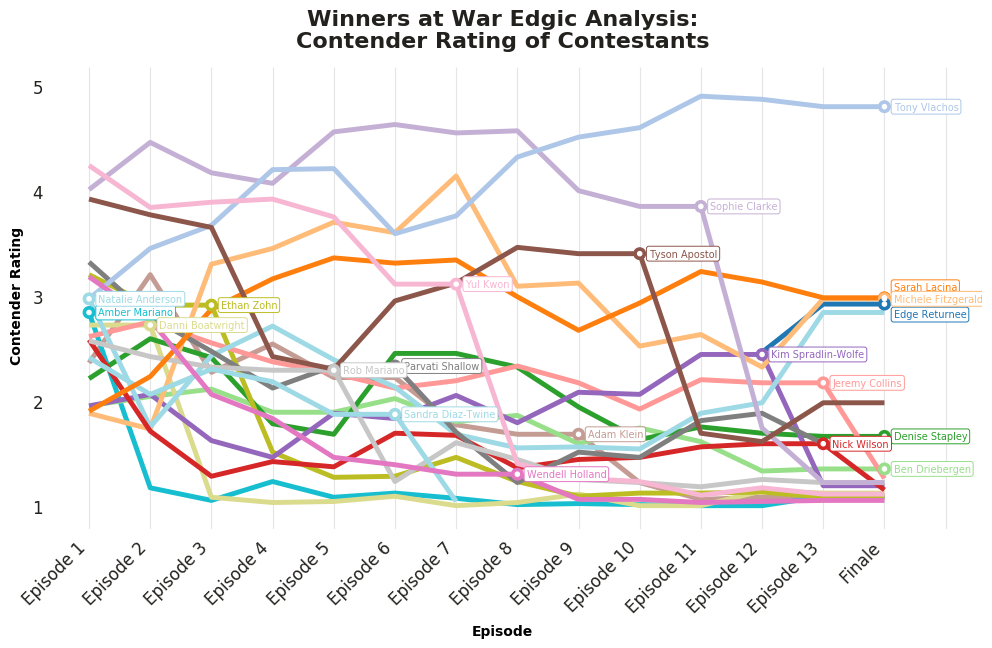

<ggplot: (-9223372036526710142)>


In [85]:
cmap_tmp = {1:"#F70020",2:"#1A7D00",3:"#0C96F2",4:"#FB9701",5:"#636666",6:"#87603E",">5":"#BFBEBB"}

for season in seasons.values():
    df = read_df(season)
    fig = base_fig(df.append(
        pd.DataFrame([['',None,None,None,None,None,None,'',None]], columns=df.columns)
        ),'finish',cmap_tmp,season) + my_theme
    ggsave(plot=fig, filename=f'./images/{season}_all_contender_ratings.png')
    print(fig)

/anaconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in less
  outside = (x < range[0]) | (x > range[1])
/anaconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in greater
  outside = (x < range[0]) | (x > range[1])
/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/anaconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 11 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)
/anaconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in less
  outside = (x < range[0]) | (x > range[1])
/anaconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in greater
  outside = (x < range[0]) | (x > range[1])
/anaconda3/lib/python3.7/site-packages/matplotlib/colors

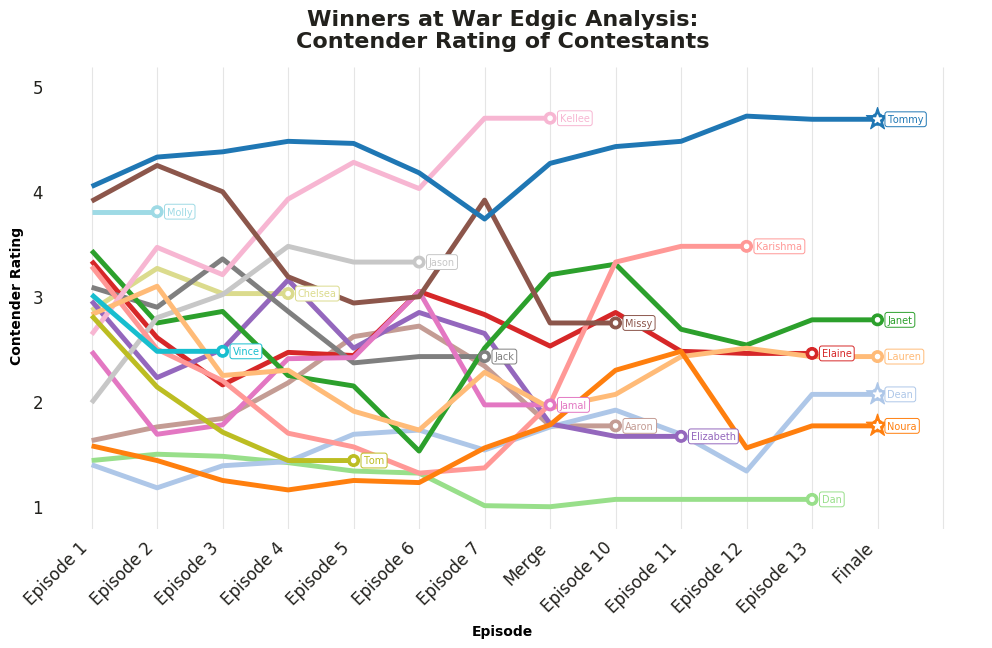

<ggplot: (325519466)>


In [54]:
df = read_df('Island of the Idols')
fig = base_fig(df.append(
    pd.DataFrame([['',None,None,None,None,None,None,'',None]], columns=df.columns)
    ),'finish',cmap_tmp,season) + my_theme
ggsave(plot=fig, filename=f'./images/{season}_all_contender_ratings.png')
print(fig)